This preamble section reads in the json file that was pulled using twarc and writes a csv. If you don't want to run this, you can skip this section and load in the csv in the descriptive analysis section.

In [18]:
import pandas as pd
import json

# read the JSONL file
with open('data/timelines/json/july_sep_2022_congress_twitter_activity.jsonl', 'r', encoding='utf8') as f:
    lines = f.readlines()

# convert each JSON object to a dictionary and store in a list
data = []
for line in lines:
    data.append(json.loads(line))

# create a dataframe from the list of dictionaries
df = pd.DataFrame(data)


In [19]:
tweets = []
for tweet in df['data']:
    for t in tweet:
        tweet_dict = {}
        tweet_dict['user_id'] = t['author_id']
        tweet_dict['text'] = t['text']
        tweet_dict['created_at'] = t['created_at']
        tweets.append(tweet_dict)

df_tweets = pd.DataFrame(tweets)

In [20]:
df_tweets.to_csv('data/timelines/csv/2022_Q3_tweets_congress.csv', index=False)

### Descriptive Analysis

First we read in the dataframe.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# get timelines
q3_tweets = pd.read_csv('data/timelines/csv/2022_Q3_tweets_congress.csv', dtype={'user_id': str})

# get metadata on twitter accounts
accounts_ids = pd.read_csv('data/congressmen_id_data.csv', dtype={'id': str}).rename({'created_at':'account_creation'}, axis=1)

# merge tweets with metatdata
q3_tweets = q3_tweets.merge(accounts_ids, how='left', left_on='user_id', right_on='id')

# convert created at to date object
q3_tweets['created_at'] = pd.to_datetime(q3_tweets['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')))

print('number of tweets:', q3_tweets.__len__())
print('number of unique ids:', q3_tweets.user_id.nunique())
print('number of accounts:', accounts_ids.__len__())

number of tweets: 114941
number of unique ids: 503
number of accounts: 511


The number of congressmen don't match the number of unique ids returned when we pull the timelines. Below are some twitter accounts that don't have any tweets in the time period we pulled:

In [2]:
accounts_ids[~accounts_ids.id.isin(q3_tweets.user_id)]['username']

10         SenatorBurr
56     SenatorMarshall
75            SenSasse
146         KenCalvert
181    RepRickCrawford
338            RepMann
426    GuamCongressman
468       RepVanTaylor
Name: username, dtype: object

After looking up Senator Burr's twitter account, it appears he hasn't tweeted since 2020, so it checks out.

### How often do congressmembers tweet?

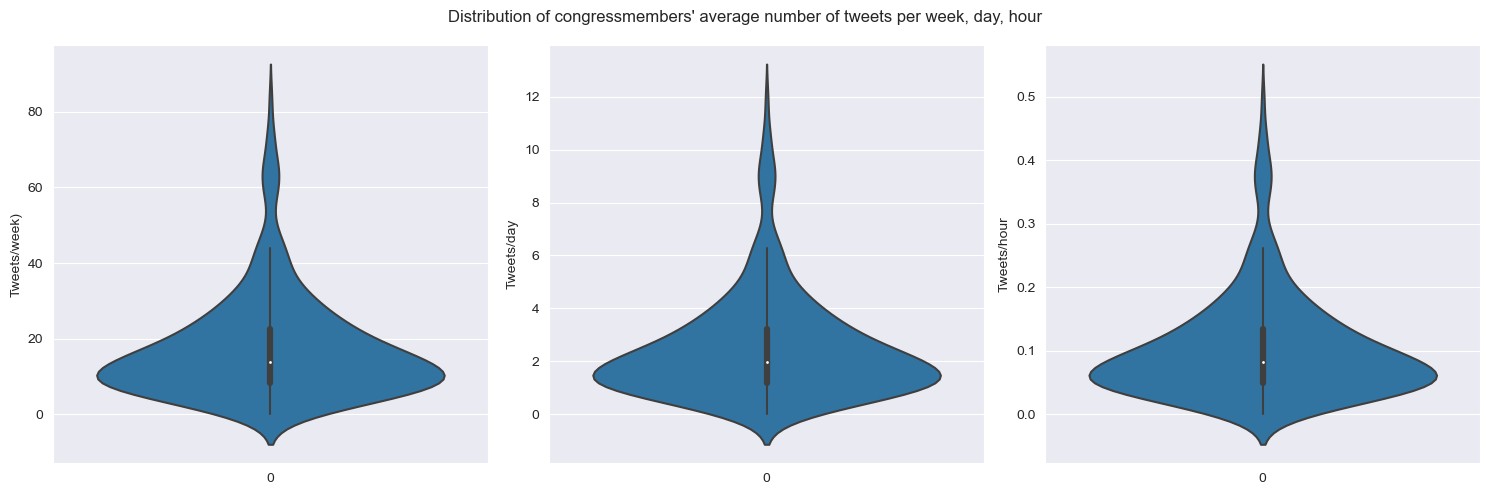

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

# Number of time period:
num_weeks = (q3_tweets.created_at.max() - q3_tweets.created_at.min()).days / 7
num_hours = (q3_tweets.created_at.max() - q3_tweets.created_at.min()).days * 24
num_days = (q3_tweets.created_at.max() - q3_tweets.created_at.min()).days

# Group the DataFrame by user ID and count the number of entries for each user
num_tweets_per_week = q3_tweets.groupby('name').agg({'created_at':'count'}).apply(lambda x: x/num_weeks).sort_values(by='created_at').created_at

# Group the DataFrame by user ID and count the number of entries for each user
num_tweets_per_day = q3_tweets.groupby('name').agg({'created_at':'count'}).apply(lambda x: x/num_days).sort_values(by='created_at').created_at

# Group the DataFrame by user ID and count the number of entries for each user
num_tweets_per_hour = q3_tweets.groupby('name').agg({'created_at':'count'}).apply(lambda x: x/num_hours).sort_values(by='created_at').created_at

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.violinplot(num_tweets_per_week, ax=axs[0])
axs[0].set_ylabel('Tweets/week)')

sns.violinplot(num_tweets_per_day, ax=axs[1])
axs[1].set_ylabel('Tweets/day')

sns.violinplot(num_tweets_per_hour, ax=axs[2])
axs[2].set_ylabel('Tweets/hour')

plt.suptitle('Distribution of congressmembers\' average number of tweets per week, day, hour')
plt.tight_layout()
plt.show()


So it appears the majority of congressmembers tweet approximately 10 times a week (a little more than once a day), while some are super-tweeters (80 times a weeks or more than 10 times a day), and plenty also don't tweet a lot. This excludes the 8 members of congress with twitter accounts that didn't tweet at all this time period.

### What does overall twitter activity look like over time?

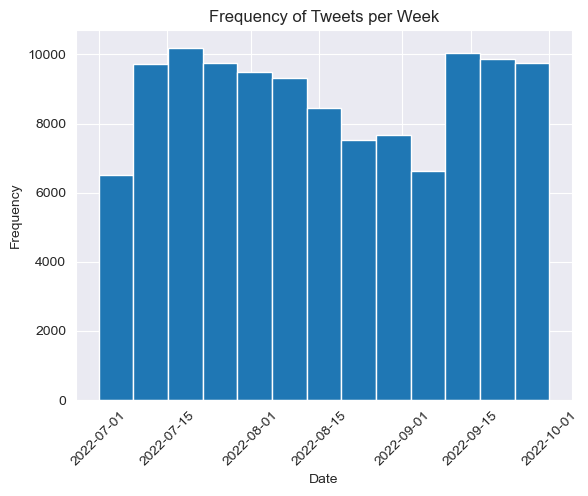

In [4]:
fig = q3_tweets.created_at.hist(bins=round(num_weeks), xrot=45)
plt.ylabel('Frequency')
plt.xlabel('Date')
plt.title('Frequency of Tweets per Week')
plt.show()

The overall activity looks to be vary between 6,000 to 10,000 tweets per week.

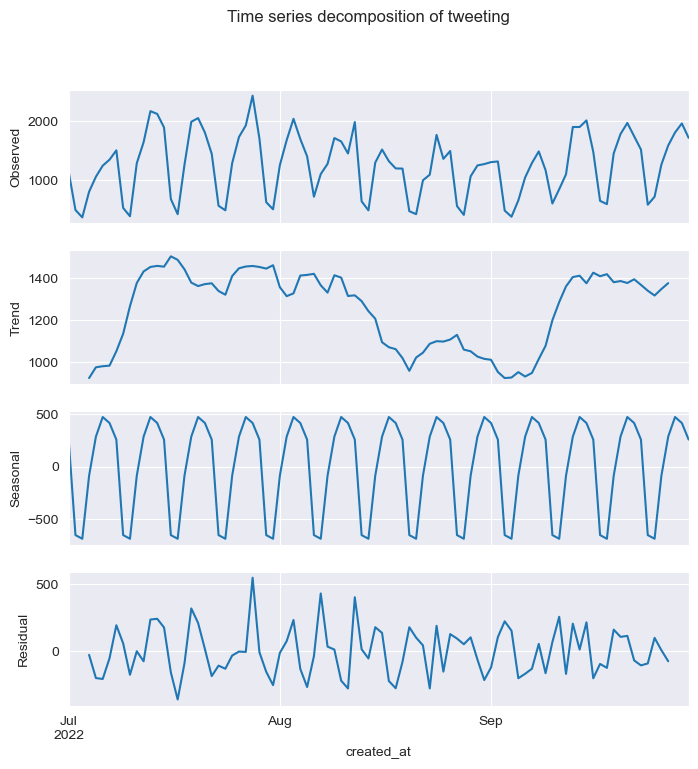

In [155]:
import statsmodels.api as sm

# Group the data by week and count the number of occurrences
daily_counts = q3_tweets.groupby(pd.Grouper(key='created_at', freq='D'))['created_at'].count().to_frame().rename({'created_at':'count'}, axis=1).reset_index()

# Set the index of the DataFrame to the date column
daily_counts.set_index('created_at', inplace=True)

# Decompose the time series into its trend, seasonal, and residual components
decomposition = sm.tsa.seasonal_decompose(daily_counts, model='additive')

# Visualize the results
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')

plt.suptitle('Time series decomposition of tweeting')
plt.show()

To produce this decomposition, we first aggregate the count of tweets on the daily level.

We can see that there's an overall trend of twitter activity, while also seasonal variation that's dependent on the day of the week. Congressmembers probably take weekends off and tweet a lot more during the weekdays.

### How often do congressmembers tweet depending on the time of day?

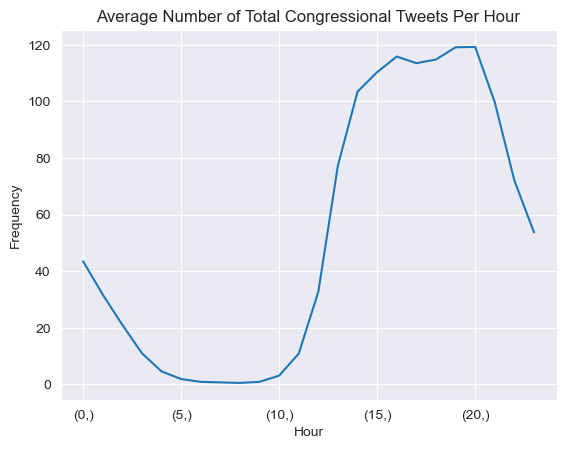

In [129]:
q3_tweets.created_at.apply(lambda x: x.hour).to_frame().value_counts().apply(lambda x: x/num_days).sort_index().plot()
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Average Number of Total Congressional Tweets Per Hour')
plt.show()

Note: this is in UTC, so the time period from 5-10 is 1-6 AM in Washington DC.

## Individual activity over time

In [90]:
import pandas as pd

# assuming your q3_tweets dataframe has columns 'date_time' and 'user_id'
# set date_time as index and group by user_id and resample by hour
q3_tweets_daily = q3_tweets[['created_at','user_id']].set_index('created_at').groupby('user_id').resample('D').count().rename({'user_id':'tweet_count'}, axis=1)
q3_tweets_hourly = q3_tweets[['created_at','user_id']].set_index('created_at').groupby('user_id').resample('H').count().rename({'user_id':'tweet_count'}, axis=1)

# pivot the table
user_daily_matrix = pd.pivot_table(q3_tweets_daily, values='tweet_count', index=['user_id'], columns=['created_at'])
user_hourly_matrix = pd.pivot_table(q3_tweets_hourly, values='tweet_count', index=['user_id'], columns=['created_at'])

# fill NaN values with 0
user_daily_matrix = user_daily_matrix.fillna(0)
user_hourly_matrix = user_hourly_matrix.fillna(0)


/Users/ericfrey/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  fig.canvas.draw()
/Users/ericfrey/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.draw()
/Users/ericfrey/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ericfrey/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


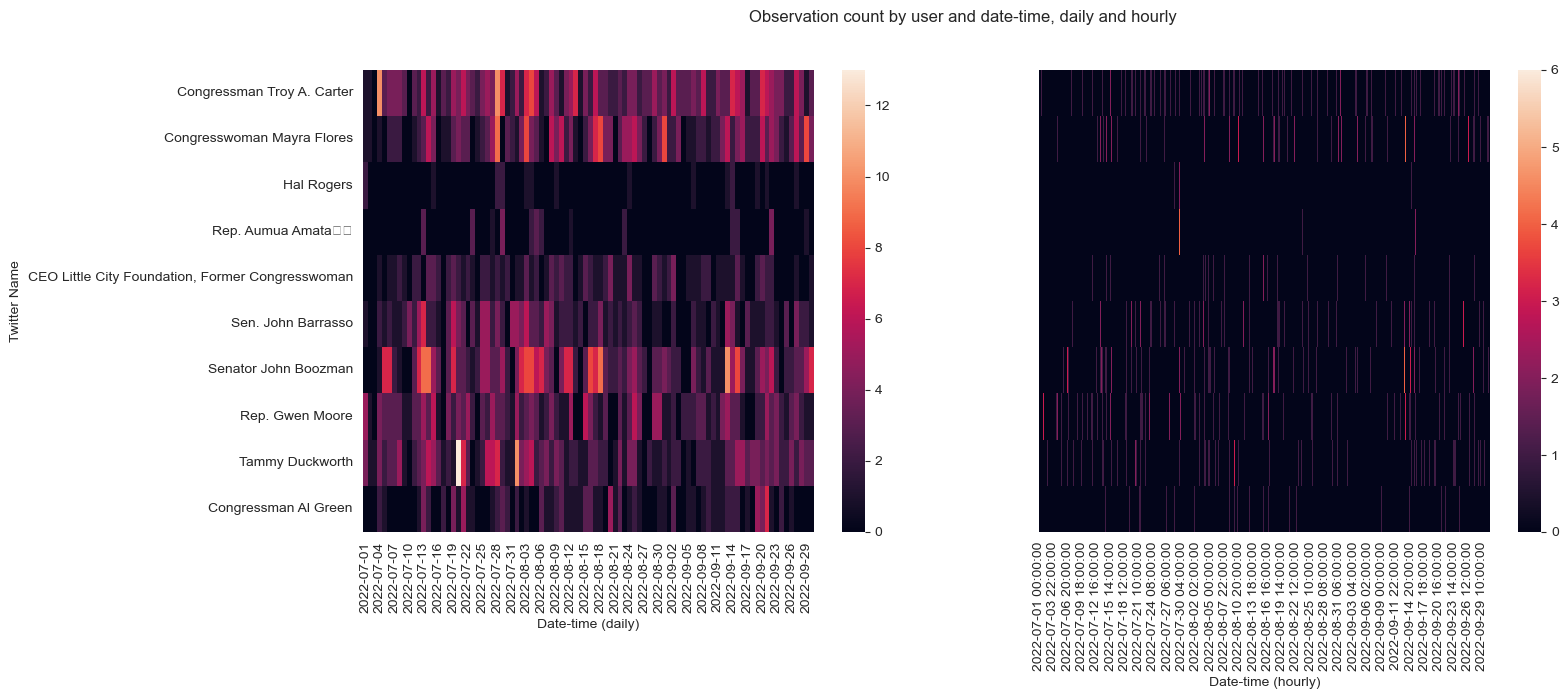

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm

# assuming you have already created the user_hourly_matrix DataFrame
# create the heatmap
np.random.seed(3)
sample = user_daily_matrix.sample(10).merge(accounts_ids[['id','name']], how='left', left_index=True, right_on='id').drop('id',axis=1).set_index('name')
sample.columns = [pd.to_datetime(col).strftime('%Y-%m-%d') for col in sample.columns]
np.random.seed(3)
hourly_sample = user_hourly_matrix.sample(10).merge(accounts_ids[['id','name']], how='left', left_index=True, right_on='id').drop('id',axis=1).set_index('name')

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(16,6))

#first heatmap
sns.heatmap(sample, ax=axs[0])

# Create the second heatmap in the right subplot
sns.heatmap(hourly_sample, ax=axs[1])

# add labels and title
axs[0].set_xlabel('Date-time (daily)')
axs[0].set_ylabel('Twitter Name')
axs[1].set_xlabel('Date-time (hourly)')
axs[1].set_ylabel('')
axs[1].set_yticklabels([])  # hide the y-axis tick labels

fig.suptitle('Observation count by user and date-time, daily and hourly')

# show the plot
plt.show()

A random sample of 10 congressmembers and the count of their tweets.

/Users/ericfrey/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  fig.canvas.draw()
/Users/ericfrey/opt/anaconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.draw()
/Users/ericfrey/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ericfrey/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


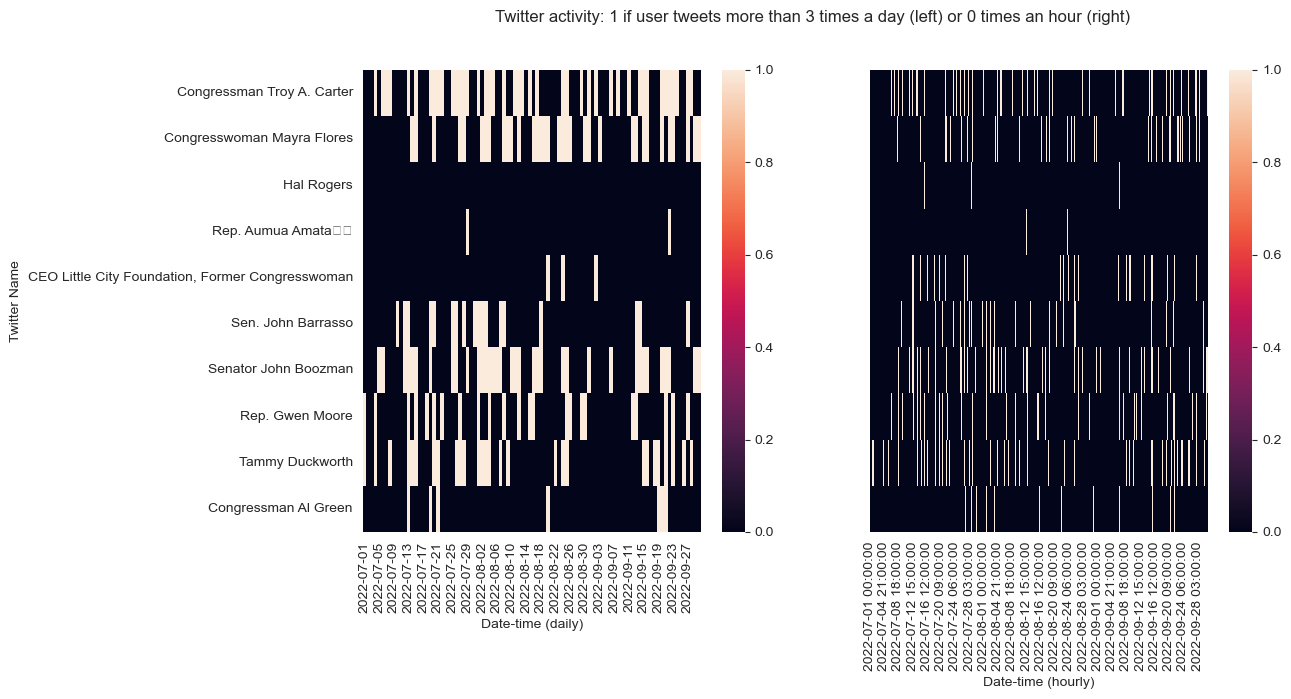

In [163]:
threshold = 3
hourly_threshold = 0
more_than_x = sample.apply(lambda x: x>threshold)
more_than_x.columns = [pd.to_datetime(col).strftime('%Y-%m-%d') for col in more_than_x.columns]
more_than_x_hourly = hourly_sample.apply(lambda x: x>hourly_threshold)

# Create a figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

#first heatmap
sns.heatmap(more_than_x, ax=axs[0])

# Create the second heatmap in the right subplot
sns.heatmap(more_than_x_hourly, ax=axs[1])

# add labels and title
axs[0].set_xlabel('Date-time (daily)')
axs[0].set_ylabel('Twitter Name')
axs[1].set_xlabel('Date-time (hourly)')
axs[1].set_yticklabels([])  # hide the y-axis tick labels
axs[1].set_ylabel("")
fig.suptitle('Twitter activity: 1 if user tweets more than {} times a day (left) or {} times an hour (right)'.format(threshold, hourly_threshold))

# show the plot
plt.show()

This visualization considers a congressmember active if they tweet more than 3 times a day or 1 time an hour.

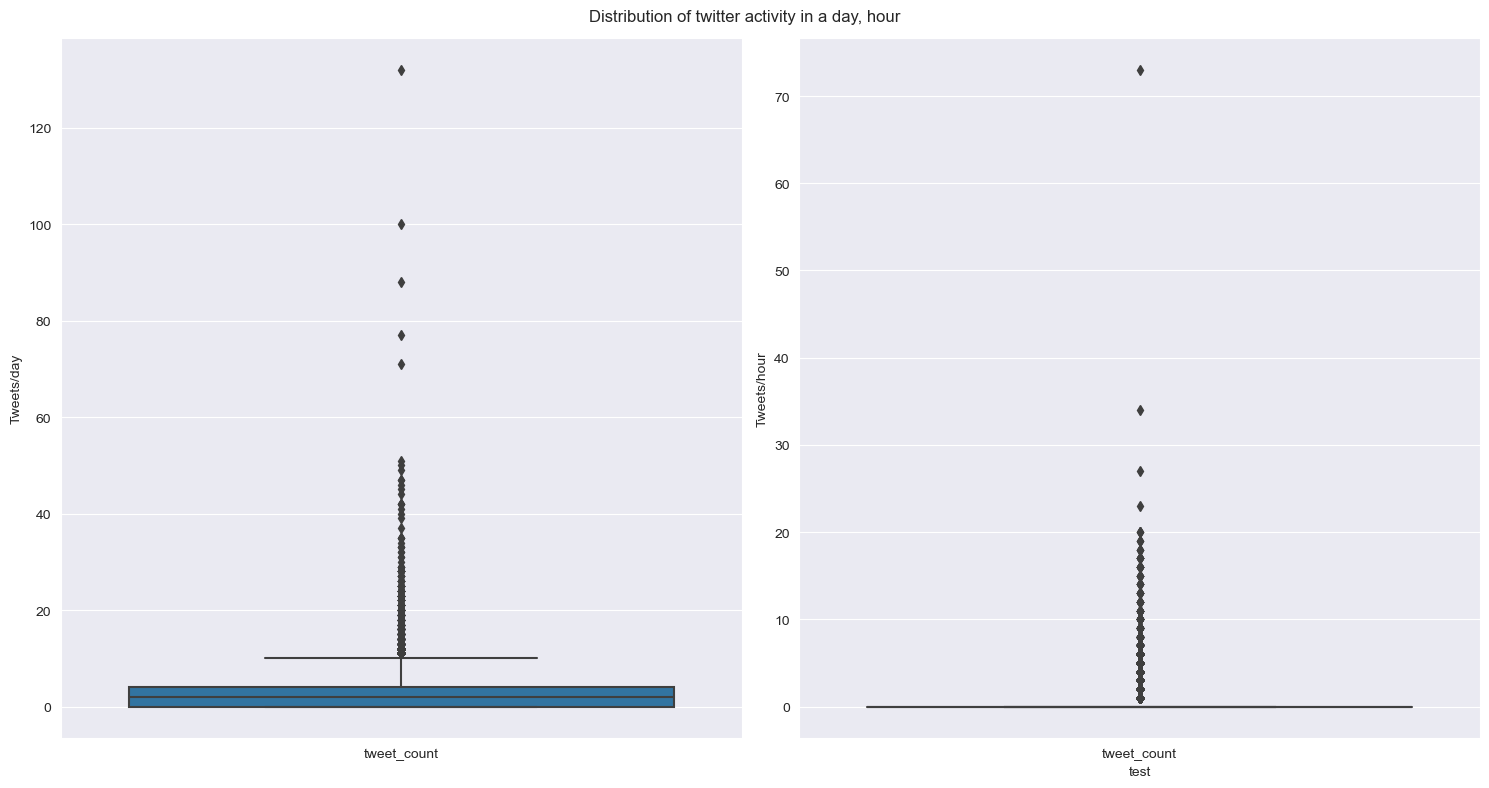

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

sns.boxplot(q3_tweets_daily, ax=axs[0])
axs[0].set_ylabel('Tweets/day')
axs[0].set_xlabel("")

sns.boxplot(q3_tweets_hourly, ax=axs[1])
axs[1].set_ylabel('Tweets/hour')
axs[1].set_xlabel("")

plt.suptitle('Distribution of twitter activity in a day, hour')
plt.tight_layout()
plt.show()

This visualization provides a distribution of the number of tweets that are tweeted both in a day and in an hour. We can see that the majority are fairly low, while there are some outliers.